# 1. Imports

In [2]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np

# 2. Data 

## 2.1 Loaders

### 2.1.1 MNIST Data

In [14]:
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
    ])
batch_size = 64

datasets_save_dir = 'Data/'

train_data = datasets.MNIST(root=datasets_save_dir,download=True,train=True, 
    transform=transform)
test_data = datasets.MNIST(root=datasets_save_dir,download=True,train=False, 
    transform=transform)

all_train_size = len(train_data)
little_train_size = int(0.8 * all_train_size)
val_size = all_train_size - little_train_size

little_train_dataset, val_dataset = random_split(train_data, [little_train_size, val_size])

little_train_dataloader = DataLoader(little_train_dataset,batch_size=batch_size,
    shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=True)
train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True)

### 2.1.2 Subsets

In [4]:
subset_sizes = [1000*i for i in range(1,6)] 

subset_loaders = []
for subset_size in subset_sizes:
    subset, _ = random_split(little_train_dataset, [subset_size, little_train_size  - subset_size])
    subset_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    subset_loaders.append(subset_loader)

## 2.2 Data shape

In [4]:
for images, labels in little_train_dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


# 3. Models

## 3.1 Standard Fcnn

In [5]:
class Fcnn(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.Softmax()
        )

    def forward(self,x):
        x = self.block_1(x)
        return x
    

    def weights_normal(self,mean,std):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=mean, std=std) 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def weights_ones(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.ones_(m.weight) 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

## 3.2 Fcnn + dropout

In [6]:
class Fcnn_dropout(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,10),
            nn.Softmax()
        )

    def forward(self,x):
        x = self.block_1(x)
        return x

# 4. Utility functions

In [16]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
         
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def train(epochs:int,model,optimizer,criterion,data,early_stop = False):
    if early_stop:
        early_stopper = EarlyStopper(patience=3)
    model.train()
    loss_history = []
    for epoch in range(epochs):
        batch_loss = []
        for batch, (images,labels) in enumerate(data):
            images = images.view(images.shape[0],-1)

            optimizer.zero_grad()
            
            output = model(images)

            loss = criterion(output,labels) 
            loss.backward()

            optimizer.step()
            
            batch_loss.append(loss.item())
            if (batch+1) % 100 == 0:
                print(f'epoch: {epoch+1}, step: {batch+1}/{len(data)}, loss: {loss.item():.4f}')
        avg_batch_loss = sum(batch_loss)/len(batch_loss)
        loss_history.append(avg_batch_loss)
        print(f'Epoch: {epoch+1}, loss: {avg_batch_loss}')

        if early_stop:
            if early_stopper.early_stop(avg_batch_loss):
                print('Early stopping!')
                break
            
    print('Finished training!')
    return loss_history



In [17]:
def test(model, dataloader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch, (images,labels) in enumerate(dataloader):
            images = images.view(images.shape[0],-1)

            output = model(images)
            pred = output.data.max(1,keepdim=True)[1]
            
            labels = labels.data.view_as(pred)
            correct += pred.eq(labels).sum()
    accuracy = correct/len(dataloader.dataset)
    print(f'Accuracy: {accuracy:.3f}')
    return accuracy


# 5. Weight initialization

W tej sekcji będziemy zajmować się analizą różnych podejść do inicjalizacji wag. Omawiane będą następujące modele:
1. Model z wagami bliskimi 0 (bez manualnej inicjalizacji)
2. Model z dużymi wagami, gdzie $\mu=1000$ oraz $\sigma = 20$
3. Model z wagami równymi 1

## 5.1 Settings

In [15]:
epochs = 8
criterion = nn.CrossEntropyLoss()

## 5.2 Training

### 5.2.1 No manual weight initialization (weights near 0)

In [16]:
model_1 = Fcnn()
optimizer = torch.optim.Adam(model_1.parameters())

loss_history_1 = train(epochs, model_1, optimizer, criterion, little_train_dataloader)

/home/luki/Dokumenty/Projekty/sieci_projekt2/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 1, step: 100/750, loss: 1.7667
epoch: 1, step: 200/750, loss: 1.7309
epoch: 1, step: 300/750, loss: 1.7765
epoch: 1, step: 400/750, loss: 1.6807
epoch: 1, step: 500/750, loss: 1.6996
epoch: 1, step: 600/750, loss: 1.5880
epoch: 1, step: 700/750, loss: 1.6511
epoch: 2, step: 100/750, loss: 1.5664
epoch: 2, step: 200/750, loss: 1.5206
epoch: 2, step: 300/750, loss: 1.5639
epoch: 2, step: 400/750, loss: 1.6075
epoch: 2, step: 500/750, loss: 1.5758
epoch: 2, step: 600/750, loss: 1.6072
epoch: 2, step: 700/750, loss: 1.5329
epoch: 3, step: 100/750, loss: 1.6031
epoch: 3, step: 200/750, loss: 1.5456
epoch: 3, step: 300/750, loss: 1.5203
epoch: 3, step: 400/750, loss: 1.5075
epoch: 3, step: 500/750, loss: 1.5416
epoch: 3, step: 600/750, loss: 1.4923
epoch: 3, step: 700/750, loss: 1.5007
epoch: 4, step: 100/750, loss: 1.4956
epoch: 4, step: 200/750, loss: 1.5445
epoch: 4, step: 300/750, loss: 1.5521
epoch: 4, step: 400/750, loss: 1.5288
epoch: 4, step: 500/750, loss: 1.5425
epoch: 4, st

### 5.2.2 Large weights

In [17]:
model_2 = Fcnn()
optimizer = torch.optim.Adam(model_2.parameters())
model_2.weights_normal(mean=1000, std=20)

loss_history_2 = train(epochs, model_2, optimizer, criterion, little_train_dataloader)

epoch: 1, step: 100/750, loss: 2.3023
epoch: 1, step: 200/750, loss: 2.3028
epoch: 1, step: 300/750, loss: 2.3025
epoch: 1, step: 400/750, loss: 2.3021
epoch: 1, step: 500/750, loss: 2.3026
epoch: 1, step: 600/750, loss: 2.3027
epoch: 1, step: 700/750, loss: 2.3025
epoch: 2, step: 100/750, loss: 2.3019
epoch: 2, step: 200/750, loss: 2.3017
epoch: 2, step: 300/750, loss: 2.3047
epoch: 2, step: 400/750, loss: 2.3028
epoch: 2, step: 500/750, loss: 2.2950
epoch: 2, step: 600/750, loss: 2.3028
epoch: 2, step: 700/750, loss: 2.3001
epoch: 3, step: 100/750, loss: 2.2998
epoch: 3, step: 200/750, loss: 2.3005
epoch: 3, step: 300/750, loss: 2.3008
epoch: 3, step: 400/750, loss: 2.2975
epoch: 3, step: 500/750, loss: 2.3063
epoch: 3, step: 600/750, loss: 2.3057
epoch: 3, step: 700/750, loss: 2.2960
epoch: 4, step: 100/750, loss: 2.3050
epoch: 4, step: 200/750, loss: 2.3005
epoch: 4, step: 300/750, loss: 2.3026
epoch: 4, step: 400/750, loss: 2.3079
epoch: 4, step: 500/750, loss: 2.2996
epoch: 4, st

### 5.2.3 All weights set to 1

In [18]:
model_3 = Fcnn()
optimizer = torch.optim.Adam(model_3.parameters())
model_3.weights_ones()

loss_history_3 = train(epochs, model_3, optimizer, criterion, little_train_dataloader)

epoch: 1, step: 100/750, loss: 2.3023
epoch: 1, step: 200/750, loss: 2.3019
epoch: 1, step: 300/750, loss: 2.3025
epoch: 1, step: 400/750, loss: 2.3023
epoch: 1, step: 500/750, loss: 2.3030
epoch: 1, step: 600/750, loss: 2.3016
epoch: 1, step: 700/750, loss: 2.3027
epoch: 2, step: 100/750, loss: 2.3026
epoch: 2, step: 200/750, loss: 2.3022
epoch: 2, step: 300/750, loss: 2.3020
epoch: 2, step: 400/750, loss: 2.2988
epoch: 2, step: 500/750, loss: 2.2984
epoch: 2, step: 600/750, loss: 2.3006
epoch: 2, step: 700/750, loss: 2.3024
epoch: 3, step: 100/750, loss: 2.2990
epoch: 3, step: 200/750, loss: 2.3029
epoch: 3, step: 300/750, loss: 2.3029
epoch: 3, step: 400/750, loss: 2.3010
epoch: 3, step: 500/750, loss: 2.3061
epoch: 3, step: 600/750, loss: 2.2971
epoch: 3, step: 700/750, loss: 2.2977
epoch: 4, step: 100/750, loss: 2.3011
epoch: 4, step: 200/750, loss: 2.2947
epoch: 4, step: 300/750, loss: 2.2949
epoch: 4, step: 400/750, loss: 2.3076
epoch: 4, step: 500/750, loss: 2.3063
epoch: 4, st

## 5.3 Results

### 5.3.1 Testing

In [21]:
accuracy_1 = test(model_1, test_dataloader)
accuracy_2 = test(model_2, test_dataloader)
accuracy_3 = test(model_3, test_dataloader)
print(f'Model 1 accuracy: {accuracy_1:.2f}, Model 2 accuracy: {accuracy_2:.2f}, Model 3 accuracy: {accuracy_3:.2f}')

/home/luki/Dokumenty/Projekty/sieci_projekt2/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy: 0.960
Accuracy: 0.113
Accuracy: 0.113
Model 1 accuracy: 0.96, Model 2 accuracy: 0.11, Model 3 accuracy: 0.11


### 5.3.2 Visualization

#### 5.3.2.1 Loss function 

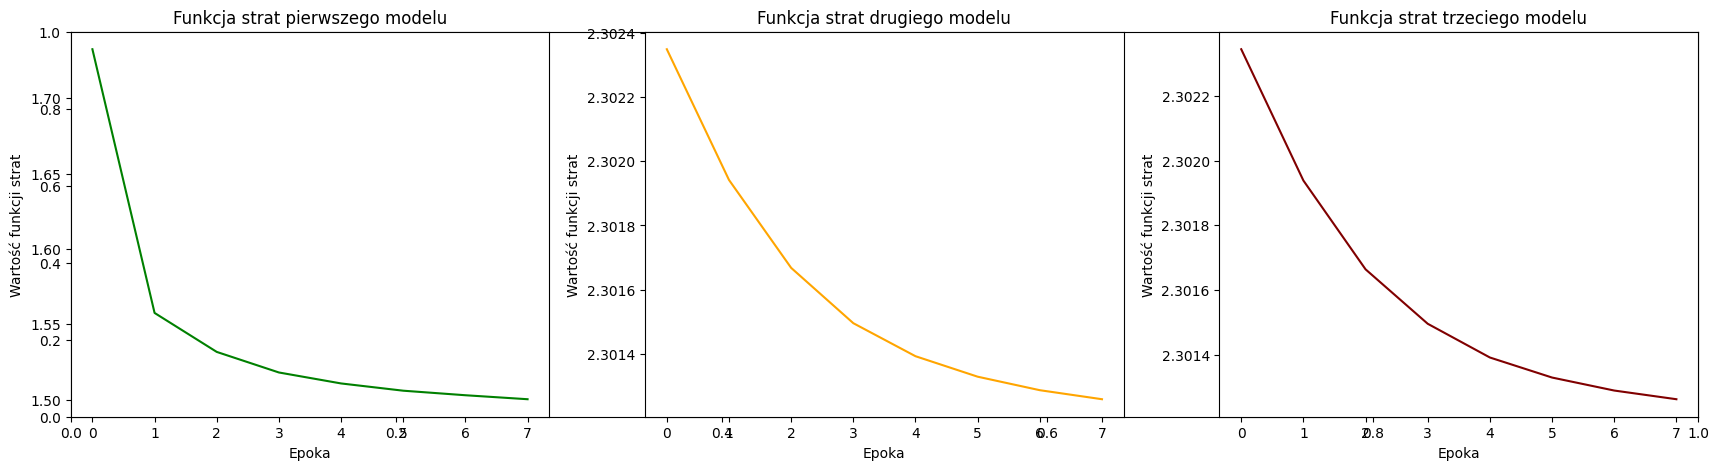

In [22]:
plt.subplots(figsize=(21, 5))

plt.subplot(1, 3, 1)
plt.plot(loss_history_1, color='green')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat pierwszego modelu')

plt.subplot(1, 3, 2)
plt.plot(loss_history_2, color='orange')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat drugiego modelu')

plt.subplot(1, 3, 3)
plt.plot(loss_history_3, color='maroon')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat trzeciego modelu')

plt.show()

#### 5.3.2.2 Accuracy barplots

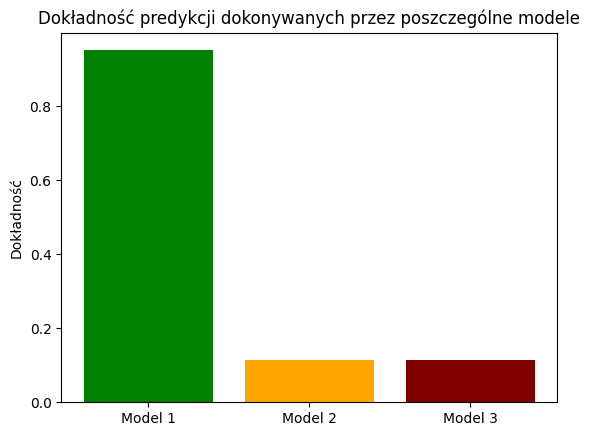

In [15]:
plt.bar(['Model 1', 'Model 2', 'Model 3'], [accuracy_1, accuracy_2, accuracy_3], color=['green', 'orange', 'maroon'])
plt.title('Dokładność predykcji dokonywanych przez poszczególne modele')
plt.ylabel('Dokładność')

plt.show()

Domyślne wagi zaimplementowane przez PyTorch (użyte w pierwszym modelu), czyli bardzo bliskie 0, działają najlepiej. Wyniki uzyskiwane przez model można wówczas uznać za satysfakcjonujące. Inicjalizacja innych wag sprawia, że wyniki predykcji modelu są bardzo dalekie od oczekiwań. Dotyczy to zarówno poprawności predykcji jak i funkcji strat.

# 6. Training on subsets of different sizes

W tym rozdziale zajmiemy się analizą uczenia sieci neuronowej w zależności od wielkości zbioru treningowego.
Następnie porównamy dokładność tych sieci na zbiorze walidacyjnym oraz testowym. 

## 6.1 Training loop

In [18]:
subset_loss_history = []
subset_accuracy_train = []
subset_accuracy_test = []

for subset in subset_loaders:
    subset_model = Fcnn()
    optimizer = torch.optim.Adam(subset_model.parameters())
    loss_history = train(3,subset_model,optimizer,criterion,subset)
    subset_loss_history.append(loss_history)

    accuracy_test = test(subset_model,test_dataloader)
    accuracy_train = test(subset_model,val_dataloader)
    
    subset_accuracy_train.append(accuracy_train)
    subset_accuracy_test.append(accuracy_test)

Finished training!
Accuracy: 0.674
Accuracy: 0.654
Finished training!
Accuracy: 0.707
Accuracy: 0.696
Finished training!
Accuracy: 0.734
Accuracy: 0.720
Finished training!
Accuracy: 0.820
Accuracy: 0.808
Finished training!
Accuracy: 0.815
Accuracy: 0.809


## 6.2 Results visualized

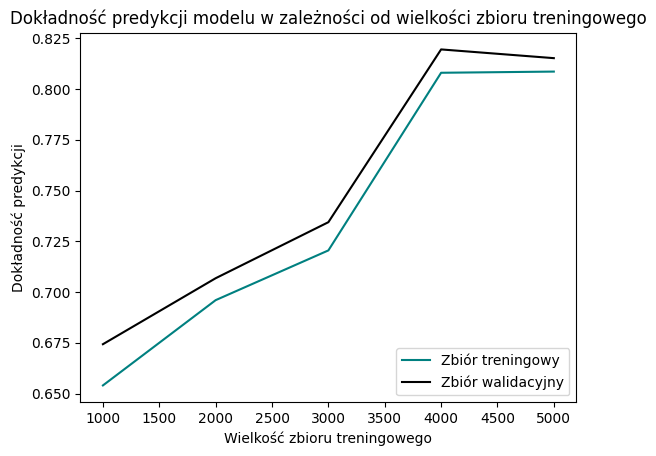

In [19]:
plt.plot(subset_sizes, subset_accuracy_train, label='Zbiór treningowy', color='teal')
plt.plot(subset_sizes, subset_accuracy_test, label='Zbiór walidacyjny', color='black')

plt.xlabel('Wielkość zbioru treningowego')
plt.ylabel('Dokładność predykcji')
plt.title('Dokładność predykcji modelu w zależności od wielkości zbioru treningowego')

plt.legend(loc='lower right')

Na powyższym wykresie możemy zauważyć trend wzrostowy w zależności pomiędzy zwiększaniem zbioru treningowego a dokładnością predykcji modelu.

# 7. Early stopping

W tym rozdziale zajmiemy się pokazaniem, w jaki sposób działa uczenie sieci neuronowej z zastosowaniem early-stoppingu. Ze względu na dużą ilość danych, by łatwiej było aktywować proces overfittingu, a tym samym aktywowania early-stoppingu, szybkość uczenia jest bardzo wysoka i wynosi 1. 

## 7.1 Training

In [18]:
epochs = 35

model_4 = Fcnn()
learning_rate = 1
optimizer = torch.optim.SGD(model_4.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
loss_history_4 = train(epochs, model_4, optimizer, criterion, data=train_dataloader,early_stop=True)

/home/luki/Dokumenty/Projekty/sieci_projekt2/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 1, step: 100/938, loss: 1.8278
epoch: 1, step: 200/938, loss: 1.7263
epoch: 1, step: 300/938, loss: 1.7993
epoch: 1, step: 400/938, loss: 1.7659
epoch: 1, step: 500/938, loss: 1.5646
epoch: 1, step: 600/938, loss: 1.6462
epoch: 1, step: 700/938, loss: 1.5772
epoch: 1, step: 800/938, loss: 1.7774
epoch: 1, step: 900/938, loss: 1.6975
epoch: 2, step: 100/938, loss: 1.6838
epoch: 2, step: 200/938, loss: 1.6472
epoch: 2, step: 300/938, loss: 1.5240
epoch: 2, step: 400/938, loss: 1.5345
epoch: 2, step: 500/938, loss: 1.5967
epoch: 2, step: 600/938, loss: 1.5230
epoch: 2, step: 700/938, loss: 1.5858
epoch: 2, step: 800/938, loss: 1.6634
epoch: 2, step: 900/938, loss: 1.6686
epoch: 3, step: 100/938, loss: 1.5543
epoch: 3, step: 200/938, loss: 1.5238
epoch: 3, step: 300/938, loss: 1.6810
epoch: 3, step: 400/938, loss: 1.5852
epoch: 3, step: 500/938, loss: 1.5427
epoch: 3, step: 600/938, loss: 1.5595
epoch: 3, step: 700/938, loss: 1.5950
epoch: 3, step: 800/938, loss: 1.5548
epoch: 3, st

## 7.2 Test

In [19]:
accuracy_4 = test(model_4, test_dataloader)

/home/luki/Dokumenty/Projekty/sieci_projekt2/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy: 0.716


## 7.3 Visualization

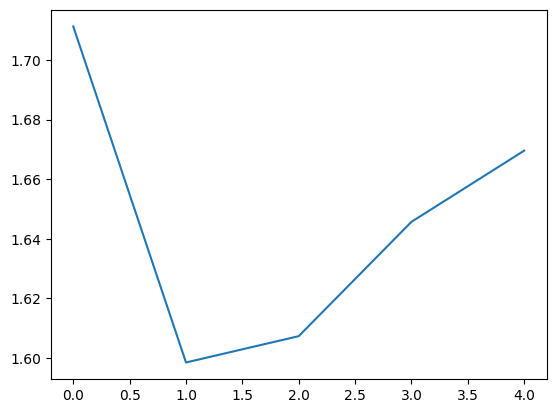

In [20]:
plt.plot(loss_history_4)

Na wykresie powyżej widać wyraźnie od pewnego momentu wzrost funkcji strat. Po ustalonych trzech epokach takiego wzrostu zadziałał early-stopping i zakończył trening.

# 8. Dropout

In [12]:
model_5 = Fcnn_dropout()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_5.parameters())

epochs = 8
train_es(epochs, model_5, optimizer, criterion, dataloader=train_dataloader)

/home/luki/Dokumenty/Projekty/sieci_projekt2/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 1, step: 100/157 , loss: 1.7145
Epoch: 1, avg_loss = 1.8717453775891832
inf 1.8717453775891832 False
epoch: 2, step: 100/157 , loss: 1.7169
Epoch: 2, avg_loss = 1.680905116591484
1.8717453775891832 1.680905116591484 False
epoch: 3, step: 100/157 , loss: 1.5644
Epoch: 3, avg_loss = 1.5990398552767031
1.680905116591484 1.5990398552767031 False
epoch: 4, step: 100/157 , loss: 1.6043
Epoch: 4, avg_loss = 1.5780316621634611
1.5990398552767031 1.5780316621634611 False
epoch: 5, step: 100/157 , loss: 1.5463
Epoch: 5, avg_loss = 1.5643549937351493
1.5780316621634611 1.5643549937351493 False
epoch: 6, step: 100/157 , loss: 1.5776
Epoch: 6, avg_loss = 1.5572135425676965
1.5643549937351493 1.5572135425676965 False
epoch: 7, step: 100/157 , loss: 1.5142
Epoch: 7, avg_loss = 1.5492765660498553
1.5572135425676965 1.5492765660498553 False
epoch: 8, step: 100/157 , loss: 1.5089
Epoch: 8, avg_loss = 1.5429607045118976
1.5492765660498553 1.5429607045118976 False
Finished training!


In [13]:
accuracy_5 = test(model_5, test_dataloader)

Accuracy: 0.942
